# Exploratory Data Analysis of IMU-Parkinson data

This notebook aims to identify characteristics of the collected data for Parkinson Disease (PD) 
screening. The data is stored as pickle or csv files in a tabular way. For each patient (in
a specific date), we have a time-series record associated, every entry in the dataset is 
a timestamp with all the measured components by the Inertial Measurement Units (IMUs).

## Required Imports

Here is the list of the required imports to execute this notebook correctly

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.settings import ROOT_DIR

##Include definition of colors for plots

## Data loading

First of all, we load the pickle file into a variable. It contains the data in a Pandas Dataframe object.

In [3]:
raw_data_path = ROOT_DIR / 'data' / 'raw'
imu_data: pd.DataFrame = pd.read_pickle(raw_data_path / 'anon_imu_data_time_series.pkl')
imu_data['anon_id'] = imu_data['anon_id'].astype(str)
type(imu_data)

pandas.core.frame.DataFrame

We have to check the amount of entries in the dataframe and how many patients and 
controls (not PD diagnosed persons) we have. Due to no patient were measured at the 
same time, we could use the `date_measure` to identify the amount of measured persons.

In [44]:
num_time_stamps = len(imu_data)
num_measured_persons = len(imu_data['date_measure'].unique())
print(f"""Number of time-stamps: {num_time_stamps}
Number of measured persons: {num_measured_persons}
""")

Number of time-stamps: 597528
Number of measured persons: 218


In [5]:
imu_data.head()

,anon_id,date_measure,time_stamp,imu_gyroX_right,imu_gyroY_right,imu_gyroZ_right,imu_accX_right,imu_accY_right,imu_accZ_right,imu_gyroX_left,...,imu_angleZ_spine,imu_angularX_left,imu_angularY_left,imu_angularZ_left,imu_angularX_right,imu_angularY_right,imu_angularZ_right,imu_angularX_spine,imu_angularY_spine,imu_angularZ_spine
0,1,,0.0,-1214.134378,-706.898961,-342.133395,8.902096,3.048967,-2.707115,-1379.007652,...,-80.931437,-10.786784,-0.300330,-0.366041,-10.036721,0.142365,-0.399272,-1.697610,-0.283670,-0.027008
1,1,,41.0,-528.943208,-481.033408,-829.426549,8.826445,3.244322,-2.375892,-444.959365,...,-146.977613,-7.828853,-0.231623,-0.163033,-6.197811,0.012145,-0.175718,5.924031,-0.119951,0.407286
2,1,,82.0,42.937833,-328.464835,-937.806656,8.769737,3.341177,-2.128276,443.239462,...,849.016319,-1.793131,-0.104697,0.184659,-0.136697,-0.158921,0.153815,3.962417,-0.201369,0.108350
3,1,,123.0,386.718612,-305.928210,-531.510961,8.782168,3.298552,-2.002942,1101.526862,...,1113.979920,6.683067,0.056346,0.567452,5.757335,-0.251148,0.422339,6.045454,0.162363,-0.061530
4,1,,164.0,399.637302,-438.997050,195.116809,8.929922,3.152229,-1.978899,1220.818122,...,963.511330,15.394780,0.213584,0.848198,9.446619,-0.194006,0.507620,-3.624151,0.095794,-0.360073


## Propotion of Controls and patients
Now we have to identify which part of those 218 persons are patients, and how many 
of them are controls. To perform that task we have to add an extra column to the 
data: `PD`. This is a binary column where 1 means the person is a patient, and 0 
is a control. We can use the excel file with all the patients id's:

In [6]:
#Read file with patients (1)
patients_ids = pd.read_excel(raw_data_path / 'CC_Patients_ASA.xlsx')
patients_ids['CC'] = patients_ids['CC'].astype(str)
patients_ids_list = patients_ids['CC'].tolist()

#Read file with all the anonymized ids
id_map = pd.read_csv(raw_data_path / 'id_map.csv')
id_map['anon_id'] = id_map['anon_id'].astype(str)
id_map['patient_id'] = id_map['patient_id'].astype(str)

def is_patient(anonymized_id: str) -> int:
    """
    anonymized_id: str with the patient's anonymized id
    returns result 1 if is patient, otherwise 0
    """
    
    real_id_list: list = id_map.loc[id_map['anon_id'] == anonymized_id, 'patient_id'].tolist()
    real_id: str = real_id_list[0] if len(real_id_list) > 0 else None
    result = 1 if real_id in patients_ids_list else 0
    
    return result

In [7]:
imu_data['PD'] = imu_data['anon_id'].apply(is_patient)

In [8]:
amount_patients = imu_data.groupby('PD')['anon_id'].nunique()
amount_patients

PD
0    154
1     39
Name: anon_id, dtype: int64

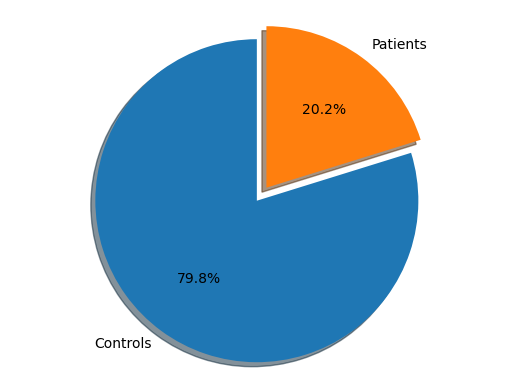

In [9]:
colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(amount_patients)))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Controls', 'Patients'
sizes = amount_patients
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We could see that the collected data is not balanced. The amount of records from patients is almost a quarter part of the amount
of controls.

## Data Insights
For every user we have 26 columns, every row is a time stamp of one user's recording Here are the dataset columns:

In [10]:
imu_data.columns.values

array(['anon_id', 'date_measure', 'time_stamp', 'imu_gyroX_right',
       'imu_gyroY_right', 'imu_gyroZ_right', 'imu_accX_right',
       'imu_accY_right', 'imu_accZ_right', 'imu_gyroX_left',
       'imu_gyroY_left', 'imu_gyroZ_left', 'imu_accX_left',
       'imu_accY_left', 'imu_accZ_left', 'imu_gyroX_spine',
       'imu_gyroY_spine', 'imu_gyroZ_spine', 'imu_accX_spine',
       'imu_accY_spine', 'imu_accZ_spine', 'imu_angleX_right',
       'imu_angleY_right', 'imu_angleZ_right', 'imu_angleX_left',
       'imu_angleY_left', 'imu_angleZ_left', 'imu_angleX_spine',
       'imu_angleY_spine', 'imu_angleZ_spine', 'imu_angularX_left',
       'imu_angularY_left', 'imu_angularZ_left', 'imu_angularX_right',
       'imu_angularY_right', 'imu_angularZ_right', 'imu_angularX_spine',
       'imu_angularY_spine', 'imu_angularZ_spine', 'PD'], dtype=object)

Is also important to clean the data and remove NaN values, but in this case, the data we are using does not have any empty value, 
or at least not in the important component form the IMUs.

In [11]:
imu_data.isnull().sum()

anon_id               0
date_measure          0
time_stamp            0
imu_gyroX_right       0
imu_gyroY_right       0
imu_gyroZ_right       0
imu_accX_right        0
imu_accY_right        0
imu_accZ_right        0
imu_gyroX_left        0
imu_gyroY_left        0
imu_gyroZ_left        0
imu_accX_left         0
imu_accY_left         0
imu_accZ_left         0
imu_gyroX_spine       0
imu_gyroY_spine       0
imu_gyroZ_spine       0
imu_accX_spine        0
imu_accY_spine        0
imu_accZ_spine        0
imu_angleX_right      0
imu_angleY_right      0
imu_angleZ_right      0
imu_angleX_left       0
imu_angleY_left       0
imu_angleZ_left       0
imu_angleX_spine      0
imu_angleY_spine      0
imu_angleZ_spine      0
imu_angularX_left     0
imu_angularY_left     0
imu_angularZ_left     0
imu_angularX_right    0
imu_angularY_right    0
imu_angularZ_right    0
imu_angularX_spine    0
imu_angularY_spine    0
imu_angularZ_spine    0
PD                    0
dtype: int64

### Records Characteristics
All timestamps are part of a measure made in a specific date. The Measure was taken during a walk of 6 to 10 meters. Movement speed is 
one of the main factors affected by PD, thus is important identify the longest walk and also the shortest to validate the data consistency.

In [24]:
records = {}
dates = imu_data['date_measure'].unique().tolist()

for date in dates:
    # Always the last value of the list is the greatest timestamp
    records[date]: float = imu_data[imu_data['date_measure'] == date]['time_stamp'].tolist()[-1]

In [25]:
max_duration = round(max(records.values())/1000, 2)
mean_duration = round(sum(records.values())/len(records)/1000, 2)
min_duration = round(min(records.values())/1000, 2)
print(f"""Average duration: {mean_duration:} s
Min duration: {min_duration} s
Max duration: {max_duration:} s
""")

Average duration: 182.95 s
Min duration: 0.82 s
Max duration: 11942.07 s


With the max, min and average duration of a walk we could realize that the **min duration is too short to be real** and 
the **max duration is huge** (In this analysis we are not considering the possibility that someone takes more than
3 hours to walk 6-10 meters). This simple values puts on evidence the presence of outliers in our records, probably some of 
them made by human error, rather than a real patient behavior.


Then we are going to identify outliers using graphs and remove them by the IQR (Inter-quantile range) method.

In [26]:
#Change the records from millis to seconds
for record in records:
    records[record] = round(records[record]/1000, 2)

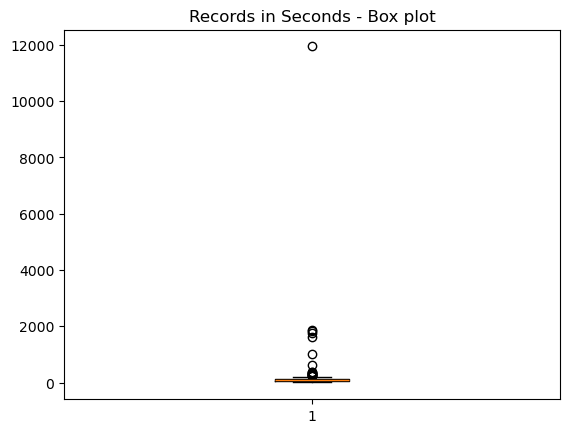

In [27]:
fig2, ax1 = plt.subplots()
plt.boxplot(records.values())
ax1.set_title('Records in Seconds - Box plot')
plt.show()

We could see that there are two main outlier, and is the previously identified max value: 11942.07 s, and the min value 
0.82 s. If we remove them and "*replot*" the records we get the following graph, which is much more consistent with the data:

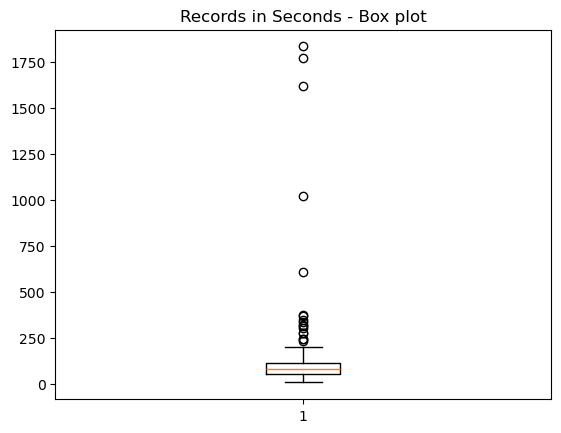

In [47]:
fig3, ax1 = plt.subplots()
plt.boxplot(sorted(records.values())[1:-1])
ax1.set_title('Records in Seconds - Box plot')
plt.show()

Before doing the outlier removal, through IQR is important to remove the delete that max value that we had before

In [32]:
max_index = list(records.values()).index(max_duration)
date_max_duration = list(records.keys())[max_index]
records.pop(date_max_duration, None)

print(max_duration, date_max_duration)

11942.07 2023-7-11-10-15-46


In [40]:
#Initialized a list for the outliers that will be removed from main dataset
outliers_date_list = [date_max_duration]

#IQR removal
q1 = np.percentile(list(records.values()), 25)
q3 = np.percentile(list(records.values()), 75)

IQR = q3 - q1
lower_bound = q1 - (1.5 * IQR)
upper_bound = q3 + 1.5 * IQR



print(f"""IQR Lower Bound: {lower_bound}
IQR Upper Bound: {upper_bound}
Q1 Lower Bound: {q1}
Q3 Upper Bound: {q3}""")

IQR Lower Bound: -36.970000000000006
IQR Upper Bound: 204.31
Q1 Lower Bound: 53.51
Q3 Upper Bound: 113.83


In [43]:
sorted(records.values())

[0.82,
 5.77,
 6.62,
 7.08,
 8.0,
 11.73,
 11.87,
 13.87,
 15.65,
 16.1,
 19.41,
 19.9,
 20.85,
 21.9,
 22.48,
 24.41,
 24.79,
 25.11,
 25.65,
 26.17,
 26.63,
 26.63,
 27.57,
 28.9,
 31.82,
 32.01,
 32.24,
 32.27,
 32.39,
 32.42,
 32.62,
 38.5,
 38.98,
 39.61,
 40.56,
 40.93,
 42.71,
 42.8,
 43.71,
 43.74,
 44.14,
 46.3,
 46.48,
 46.56,
 46.67,
 46.74,
 47.89,
 48.34,
 48.44,
 49.33,
 49.87,
 50.69,
 51.76,
 52.28,
 53.51,
 53.6,
 53.94,
 55.68,
 56.68,
 57.26,
 59.44,
 60.66,
 60.74,
 61.52,
 61.72,
 62.47,
 62.72,
 63.7,
 63.85,
 63.9,
 64.05,
 64.64,
 65.1,
 65.49,
 65.6,
 65.94,
 66.35,
 66.76,
 66.89,
 67.12,
 67.72,
 67.83,
 68.51,
 68.64,
 68.68,
 68.72,
 68.97,
 69.24,
 69.32,
 70.63,
 71.03,
 71.11,
 71.33,
 72.03,
 72.47,
 72.52,
 73.24,
 73.34,
 74.61,
 74.73,
 74.79,
 74.81,
 75.54,
 75.69,
 75.88,
 75.99,
 76.26,
 77.35,
 77.88,
 78.08,
 79.94,
 80.21,
 81.2,
 82.19,
 82.53,
 82.75,
 84.98,
 85.11,
 86.01,
 86.61,
 87.81,
 87.97,
 87.98,
 88.1,
 88.23,
 88.26,
 88.72,
 88.